In [66]:
# Setup

# Characters are represented by 1-hot vectors of size 128
char_dim = 128

import numpy as np
import os
from collections import Counter
import unicodedata
import string
import gc
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import LSTM
from torch import optim

In [17]:
# replaces special characters with their close equivalents in order to simplify the characters that appear
def clean_text(text):
    # TODO I goofed this function. It replaces newline characters with the literal characters \n, undesirably. Fix it later.
    return str(unicodedata.normalize('NFD', text).encode('ascii', 'ignore'))

file = open('beatles.txt', 'r')
beatleslyrics = ''
# ignore lines that consist of 'TOP'
line = file.readline()
while line != '':
    beatleslyrics += line
    line = file.readline()
file.close()
beatleslyrics = clean_text(beatleslyrics)
print('read %d characters' % len(beatleslyrics))
char_counter = Counter(beatleslyrics)
print(char_counter)

for key in char_counter.keys():
    if ord(key) >= 128:
        print('invalid character value found: %s has numeric value %d', key, ord(key))

read 148667 characters
Counter({' ': 24384, 'n': 13118, 'e': 13002, 'o': 9898, 't': 8128, 'a': 7361, '\\': 5725, 'h': 5718, 'l': 5473, 'i': 5456, 's': 4862, 'r': 4848, 'y': 4260, 'd': 3771, 'u': 3528, 'm': 3125, 'g': 2673, 'w': 2581, ',': 2026, 'I': 1938, 'b': 1810, 'c': 1681, '.': 1438, 'k': 1382, 'v': 1269, 'f': 1256, 'p': 1085, "'": 985, 'T': 559, 'S': 492, 'A': 481, 'W': 409, 'O': 339, 'P': 296, 'B': 293, 'Y': 277, 'H': 236, '-': 228, 'L': 210, 'D': 208, 'M': 199, 'C': 161, 'N': 143, 'j': 137, 'G': 132, '(': 117, ')': 117, 'E': 107, 'R': 106, '?': 101, 'F': 95, 'z': 72, 'J': 69, 'x': 69, '!': 48, 'K': 46, 'U': 30, 'q': 18, '9': 15, ']': 12, 'V': 10, ';': 9, '[': 9, '0': 9, 'Q': 5, '1': 4, '5': 3, '"': 2, '2': 2, '3': 2, '4': 2, '7': 2, ':': 2, '/': 1, '6': 1, '8': 1})


In [22]:
# converts a list of N strings of length T into a numpy array of 1-hot vectors
# input size: (N, T)
# output size: (T, N, 128)
i128 = np.eye(128)
def char_to_ix(texts):
    T = max([len(text) for text in texts])
    ords = np.zeros((T, len(texts)), dtype=int)
    for n, text in enumerate(texts):
        ords[:len(text), n] = [ord(char) for char in text]
    return i128[ords]

# converts a list of N strings of length <=T into a numpy array of length (T, N).
# Zero-pads shorter strings.
def char_to_array(texts):
    T = max([len(text) for text in texts])
    result = np.zeros((T, len(texts)), dtype=int)
    for n, text in enumerate(texts):
        result[:len(text), n] = [ord(char) for char in text]
    return result
    #ords = np.array([[ord(char) for char in text] for text in texts], dtype=int)
    #return ords.transpose((1, 0))

In [30]:
# free some memory if possible
train_data = None
val_data = None
test_data = None
val_data_ix = None
val_data_array = None
test_data_ix = None
test_data_array = None
gc.collect()

train_data = ''
val_data = ''
test_data = ''

# the string TOP separates all songs
songs = beatleslyrics.split('TOP\\n')
print('number of songs: %d' % len(songs))
np.random.seed(0)
np.random.shuffle(songs)

train_data = songs[:len(songs) * 34 // 100]
val_data   = songs[len(songs) * 34 // 100:len(songs) * 67 // 100]
test_data  = songs[len(songs) * 67 // 100:]

train_data_ix = torch.tensor(char_to_ix(train_data), dtype=torch.float)
train_data_array = torch.tensor(char_to_array(train_data))

print(train_data_ix.shape)
print(train_data_array.shape)

val_data_ix = torch.tensor(char_to_ix(val_data), dtype=torch.float)
val_data_array = torch.tensor(char_to_array(val_data))

test_data_ix = torch.tensor(char_to_ix(test_data), dtype=torch.float)
test_data_array = torch.tensor(char_to_array(test_data))

print(len(train_data))
print(len(val_data))
print(len(test_data))

number of songs: 181
torch.Size([1770, 61, 128])
torch.Size([1770, 61])
61
60
60


In [45]:
class BeatlesLSTM(nn.Module):
    def __init__(self, hidden_dim, num_stacks):
        super(BeatlesLSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(char_dim, hidden_dim, num_layers=num_stacks, dropout=0.0)
        
        # The linear layer that maps from hidden state space to character space
        self.hidden2char = nn.Linear(hidden_dim, char_dim)
        self.init_hidden_zeros(1)
    
    def init_hidden_zeros(self, minibatch_size):
        self.init_hidden(torch.zeros((self.lstm.num_layers, minibatch_size, self.hidden_dim)), torch.zeros((self.lstm.num_layers, minibatch_size, self.hidden_dim)))
    
    def init_hidden(self, h, c):
        self.hidden = (h, c)

    def forward(self, text):
        # text should be of size (T, N, char_dim)
        # returns character scores of size (T, N, char_dim)
        
        hs, self.hidden = self.lstm(text, self.hidden)
        char_space = self.hidden2char(hs)
        return char_space

In [43]:
def model_loss(model, loss_func, data_ix, data_array):
    model.lstm.eval()
    this_minibatch_size = data_ix.shape[1]
    model.init_hidden_zeros(this_minibatch_size)
    sequence_in = data_ix[:-1, :, :]
    #sequence_out = data_array[1:, :]

    #char_scores = model(sequence_in)
    #loss = loss_func(char_scores.view(-1, char_dim), sequence_out.view(-1))
    loss = 0
    with torch.no_grad():
        for i, char_in in enumerate(sequence_in):
            char_scores = model(char_in.view(1, this_minibatch_size, -1))
            loss += loss_func(char_scores.view(-1, char_dim), data_array[i+1,:])
    model.lstm.train()
    return loss / len(sequence_in)

on epoch 0
	on iteration 14 / 15
	training loss = 1.928874
	validation loss = 2.081647
on epoch 1
	on iteration 14 / 15
	training loss = 1.471978
	validation loss = 1.611229
on epoch 2
	on iteration 14 / 15
	training loss = 1.275568
	validation loss = 1.402449
on epoch 3
	on iteration 14 / 15
	training loss = 1.182001
	validation loss = 1.303262
on epoch 4
	on iteration 14 / 15
	training loss = 1.091965
	validation loss = 1.209699
on epoch 5
	on iteration 14 / 15
	training loss = 1.051820
	validation loss = 1.169946
on epoch 6
	on iteration 14 / 15
	training loss = 1.019763
	validation loss = 1.143764
on epoch 7
	on iteration 14 / 15
	training loss = 0.998386
	validation loss = 1.125143
on epoch 8
	on iteration 14 / 15
	training loss = 0.978582
	validation loss = 1.109978
on epoch 9
	on iteration 14 / 15
	training loss = 0.959731
	validation loss = 1.096035
on epoch 10
	on iteration 14 / 15
	training loss = 0.935922
	validation loss = 1.083305
on epoch 11
	on iteration 14 / 15
	trainin

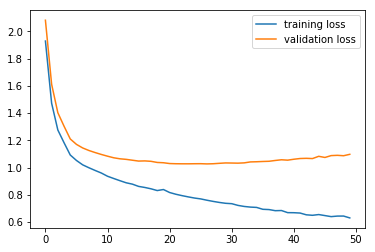

on epoch 0
	on iteration 14 / 15
	training loss = 1.702667
	validation loss = 1.865921
on epoch 1
	on iteration 14 / 15
	training loss = 1.569584
	validation loss = 1.725635
on epoch 2
	on iteration 14 / 15
	training loss = 1.594948
	validation loss = 1.754186
on epoch 3
	on iteration 14 / 15
	training loss = 1.513970
	validation loss = 1.665890
on epoch 4
	on iteration 14 / 15
	training loss = 1.435095
	validation loss = 1.582675
on epoch 5
	on iteration 14 / 15
	training loss = 1.370302
	validation loss = 1.512260
on epoch 6
	on iteration 14 / 15
	training loss = 1.282757
	validation loss = 1.414188
on epoch 7
	on iteration 14 / 15
	training loss = 1.231578
	validation loss = 1.358985
on epoch 8
	on iteration 14 / 15
	training loss = 1.188718
	validation loss = 1.313914
on epoch 9
	on iteration 14 / 15
	training loss = 1.158261
	validation loss = 1.283659
on epoch 10
	on iteration 14 / 15
	training loss = 1.123090
	validation loss = 1.248646
on epoch 11
	on iteration 14 / 15
	trainin

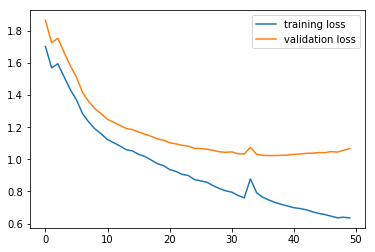

on epoch 0
	on iteration 14 / 15
	training loss = 2.290074
	validation loss = 2.463826
on epoch 1
	on iteration 14 / 15
	training loss = 2.288628
	validation loss = 2.464976
on epoch 2
	on iteration 14 / 15
	training loss = 2.271879
	validation loss = 2.445744
on epoch 3
	on iteration 14 / 15
	training loss = 2.260106
	validation loss = 2.428253
on epoch 4
	on iteration 14 / 15
	training loss = 2.256854
	validation loss = 2.424189
on epoch 5
	on iteration 14 / 15
	training loss = 2.257251
	validation loss = 2.420581
on epoch 6
	on iteration 14 / 15
	training loss = 2.250508
	validation loss = 2.413440
on epoch 7
	on iteration 14 / 15
	training loss = 2.776002
	validation loss = 3.042617
on epoch 8
	on iteration 14 / 15
	training loss = 2.268722
	validation loss = 2.442250
on epoch 9
	on iteration 14 / 15
	training loss = 2.261897
	validation loss = 2.432681
on epoch 10
	on iteration 14 / 15
	training loss = 2.258280
	validation loss = 2.427777
on epoch 11
	on iteration 14 / 15
	trainin

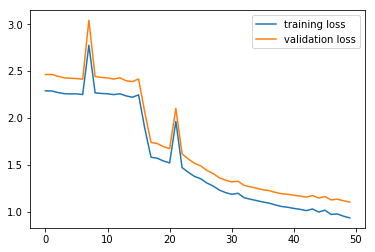

In [70]:
model = BeatlesLSTM(64, 1)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_1h = []
val_losses_1h = []
minibatch_size = 4

for epoch in range(50):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_1h += [train_loss]
    val_losses_1h += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_1layer_mb4_epoch' + str(epoch))

ts = np.arange(50)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_1h), np.argmin(val_losses_1h)))
plt.plot(ts, train_losses_1h, label='training loss')
plt.plot(ts, val_losses_1h, label='validation loss')
plt.legend(loc='best')
plt.show()

#######################################

model = BeatlesLSTM(64, 2)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_2h = []
val_losses_2h = []
minibatch_size = 4

for epoch in range(50):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_2h += [train_loss]
    val_losses_2h += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_2layer_mb4_epoch' + str(epoch))

ts = np.arange(50)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_2h), np.argmin(val_losses_2h)))
plt.plot(ts, train_losses_2h, label='training loss')
plt.plot(ts, val_losses_2h, label='validation loss')
plt.legend(loc='best')
plt.show()

########################################

model = BeatlesLSTM(64, 3)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_3h = []
val_losses_3h = []
minibatch_size = 4

for epoch in range(50):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_3h += [train_loss]
    val_losses_3h += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_3layer_mb4_epoch' + str(epoch))

ts = np.arange(50)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_3h), np.argmin(val_losses_3h)))
plt.plot(ts, train_losses_3h, label='training loss')
plt.plot(ts, val_losses_3h, label='validation loss')
plt.legend(loc='best')
plt.show()

on epoch 0
	on iteration 14 / 15
	training loss = 2.162390
	validation loss = 2.320721
on epoch 1
	on iteration 14 / 15
	training loss = 1.605904
	validation loss = 1.760290
on epoch 2
	on iteration 14 / 15
	training loss = 1.506062
	validation loss = 1.652330
on epoch 3
	on iteration 14 / 15
	training loss = 1.437540
	validation loss = 1.582369
on epoch 4
	on iteration 14 / 15
	training loss = 1.303930
	validation loss = 1.435563
on epoch 5
	on iteration 14 / 15
	training loss = 1.224603
	validation loss = 1.351673
on epoch 6
	on iteration 14 / 15
	training loss = 1.170980
	validation loss = 1.295735
on epoch 7
	on iteration 14 / 15
	training loss = 1.140588
	validation loss = 1.264374
on epoch 8
	on iteration 14 / 15
	training loss = 1.110794
	validation loss = 1.235110
on epoch 9
	on iteration 14 / 15
	training loss = 1.089338
	validation loss = 1.214488
on epoch 10
	on iteration 14 / 15
	training loss = 1.074432
	validation loss = 1.200939
on epoch 11
	on iteration 14 / 15
	trainin

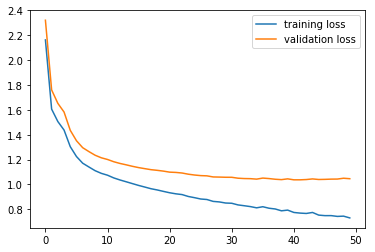

on epoch 0
	on iteration 14 / 15
	training loss = 2.267428
	validation loss = 2.439463
on epoch 1
	on iteration 14 / 15
	training loss = 2.261727
	validation loss = 2.431058
on epoch 2
	on iteration 14 / 15
	training loss = 2.257776
	validation loss = 2.425856
on epoch 3
	on iteration 14 / 15
	training loss = 2.251332
	validation loss = 2.419355
on epoch 4
	on iteration 14 / 15
	training loss = 2.268915
	validation loss = 2.447333
on epoch 5
	on iteration 14 / 15
	training loss = 1.621069
	validation loss = 1.774583
on epoch 6
	on iteration 14 / 15
	training loss = 1.577818
	validation loss = 1.733560
on epoch 7
	on iteration 9 / 15

In [ ]:
model = BeatlesLSTM(32, 2)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_2h_32 = []
val_losses_2h_32 = []
minibatch_size = 4

for epoch in range(50):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_2h_32 += [train_loss]
    val_losses_2h_32 += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h32s_2layer_mb4_epoch' + str(epoch))

ts = np.arange(50)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_2h), np.argmin(val_losses_2h)))
plt.plot(ts, train_losses_2h_32, label='training loss')
plt.plot(ts, val_losses_2h_32, label='validation loss')
plt.legend(loc='best')
plt.show()

########################################

model = BeatlesLSTM(32, 3)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_3h_32 = []
val_losses_3h_32 = []
minibatch_size = 4

for epoch in range(50):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_3h_32 += [train_loss]
    val_losses_3h_32 += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h32s_3layer_mb4_epoch' + str(epoch))

ts = np.arange(50)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_3h), np.argmin(val_losses_3h)))
plt.plot(ts, train_losses_3h_32, label='training loss')
plt.plot(ts, val_losses_3h_32, label='validation loss')
plt.legend(loc='best')
plt.show()

In [60]:
softmax = torch.nn.Softmax()
chars = range(128)

def sample_char(char_scores, temp):
    char_scores = softmax(char_scores / temp)
    char = np.random.choice(chars, p=char_scores.detach().numpy())
    while not chr(char) in string.printable and char != 0:
        char = np.random.choice(chars, p=char_scores.detach().numpy())
    return char

def sample(model, first_char, init_hidden, T, temp):
    model.init_hidden_zeros(1)
    result = first_char
    cur_char = ord(first_char)
    for t in range(T):
        one_hot_char = torch.tensor(i128[cur_char], dtype=torch.float).view(1, 1, -1)
        char_scores = model(one_hot_char)
        cur_char = sample_char(char_scores.view(-1), temp)
        if cur_char == 0:
            return result
        result += chr(cur_char)
    return result

sampled_song = sample(model, '\\', torch.zeros((1, 1, model.hidden_dim)), 500, 0.5).replace('\\n', '\n')
print(sampled_song)

/home/alex/bin/anaconda3/envs/cs682/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """



For the sand all to see it abopt me.

I dont lat a do.
Some me be me the some it a man the mard the say
Its what I want)
She good it want of near bele to the mand the mo.
You know I love it's it all the slead,
If you know I love me

Somed Im the some loverstreed the girl
Its the mind it bebely Fielly don't here with you,
You know the some foot en the way
I want to pleave me

I find me.

I say the song to be you say the man the fear.


